### 7.6.1 첫번째 층의 가중치 시각화하기

In [1]:
from common.optimizer import *
from dataset.mnist import load_mnist

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        # if self.verbose:
        print("=============== Final Test Accuracy ===============")
        print("test acc:" + str(test_acc))

In [2]:
from common.simple_convnet import SimpleConvNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000, verbose=False)
trainer.train()

=============== Final Test Accuracy ===============
test acc:0.953


In [4]:
import os
import pickle

# 학습 후에만 실행할 것
# os.makedirs('params', exist_ok=True)
# with open('params/wb.pickle', 'wb') as f:
#     pickle.dump(network.params, f)

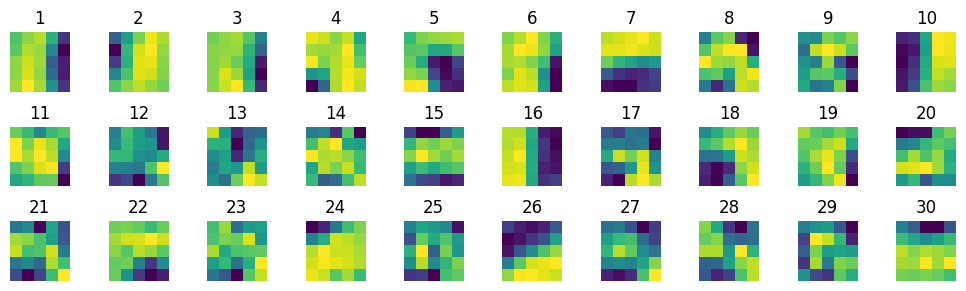

In [67]:
import matplotlib.pyplot as plt

with open('params/wb.pickle', 'rb') as f:
    params = pickle.load(f)

fig = plt.figure(figsize=(10, 3))

for i in range(1, 4):
    for j in range(1, 11):
        idx = 10*(i-1)+j - 1
        # print(i, j, idx)

        fig.add_subplot(3, 10, idx+1)
        w1_img = params['W1'][idx]
        w1_img = w1_img.transpose(2, 1, 0)
        plt.imshow(w1_img)
        plt.axis('off')
        plt.title(idx+1)
        
plt.tight_layout()

<p align="center"><img src="imgs/7-25.png" width=600></p>

* 학습 후에 필터는 일종의 규칙을 띄게 된다.
* 이미지에서 비슷한 모양이 있는 구간에서, 필터가 활성화된다.

### 7.6.3 층 깊이에 따른 추출 정보 변화

1. Edge + Blob
2. Texture
3. Object parts
4. object classes

레이어가 깊어질 수록, 필터도 추상적이 된다. 추상적이라는 것은 더 많은 정보를 담고 있다는 뜻이다.

<p align="center"><img src="imgs/7-26-1.png" width=800></p>